# Source Code for implementing ACO for the MAPF problem

* Create algorithm for ACO
* Create test promles
* Create algorithm for time-expansion of the graph
* Create Multi-Agent-ACO solver

In [1]:
# install the required packages
%pip install matplotlib pandas seaborn numpy networkx ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(threshold=np.inf)
import networkx as nx
import ipywidgets as widgets

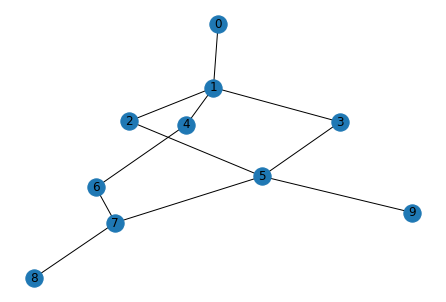

In [3]:
G = nx.Graph()
G.add_edge(0, 1, weight=1)
G.add_edge(1, 2, weight=1.5)
G.add_edge(1, 3, weight=1)
G.add_edge(3, 5, weight=1)
G.add_edge(1, 4, weight=3)
G.add_edge(2, 5, weight=1)
G.add_edge(4, 6, weight=1)
G.add_edge(5, 7, weight=1)
G.add_edge(6, 7, weight=3)
G.add_edge(7, 8, weight=1)
G.add_edge(5, 9)
nx.draw(G, with_labels=True)

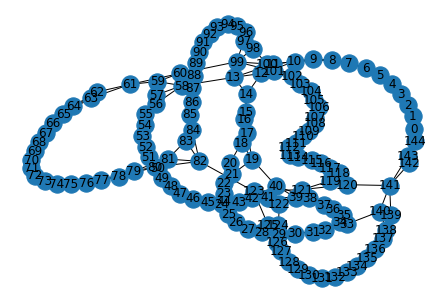

In [4]:
G = nx.watts_strogatz_graph(145,4, 0.01, seed=42)
nx.draw(G,with_labels=True)
for e in G.edges():
    G[e[0]][e[1]]['weight']= 0.5 + np.random.rand()
graphstart = 0
graphgoal = 75

In [5]:
m = nx.adjacency_matrix(G)

In [32]:
class Ant:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        self.stuck = False
        
        self.setup()
        
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, value = 0.5):
        factor = 1 * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
    def delayed_update(self):
        amount = 1/self.distance
        for i in range(len(self.path)-1):
            self.pheromones[self.path[i], self.path[i+1]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
            self.pheromones[self.path[i+1], self.path[i]] += amount #/ self.adjacency[self.path[i], self.path[i+1]]
            
    
    def random_selection(self, new):
        return np.random.choice(new)
    
    def value(self, i, j, alpha=0.5, beta=0.5, **kwargs):
        d = 1 / self.adjacency[i,j]
        return self.pheromones[i,j]**alpha * (1/d)**beta
    
    def ant_system_selection(self, new, **kwargs):
        probs = {k : self.value(self.state, k, **kwargs) for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                x = k
                break
        assert(cutoff <= 0)
        return x
    
    def roulette_wheel_selection(self, new):
        probs = {k : self.pheromones[self.state, k] for k in new }
        cutoff = np.random.rand()
        s = sum(probs.values())
        x = new[-1]
        for k, v in probs.items():
            cutoff -= v / s
            if cutoff < 0:
                x = k
                break
        assert(cutoff <= 0)
        return x

    def setup(self, start=None, goal=None, **kwargs):
        if start:
            self.start = start
        if goal:
            self.goal = goal
        self.stuck = False
        self.state = self.start
        self.path = [self.start]
        self.distance = 0
            
    def step(self, selection=None, **kwargs):
        if not selection:
            selection = self.ant_system_selection
        
        # compute next possible states $new
        new = [node for node in range(len(self.adjacency)) if not(node in self.path or self.adjacency[self.state, node] == 0)]
        # in case no more states are possible: return
        if not new:
            self.stuck=True
            return
        
        # pick a new state from the list
        self.state = selection(new, **kwargs)
        self.path.append(self.state)
        d = self.adjacency[self.path[-2], self.path[-1]]
        #print(f"current distance: {d}")
        self.distance += d
    
    def draw_pheromones(self, label=True):
        G = nx.from_numpy_matrix(self.pheromones)
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [w['weight'] * 2 for u, v, w in G.edges(data=True)]
        nx.draw(G,pos=pos,with_labels=True, width=width)
        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        

        

class ACO:
    def __init__(self, start = 0, goal = None, pheromones = None, adjacency = None, **kwargs):
        self.start = start
        self.goal = goal
        self.pheromones = pheromones
        self.adjacency = adjacency
        assert pheromones.shape == adjacency.shape
        for i in range(adjacency.shape[0]):
            for j in range(adjacency.shape[1]):
                if adjacency[i, j] == 0:
                    self.pheromones[i, j] = 0
        
        self.pheromone_timeline = [pheromones.copy()]
        self.create_ants()

        
    def create_ants(self, num_ants = 10):
        self.ants = [Ant(start=self.start, goal=self.goal, pheromones=self.pheromones, adjacency=self.adjacency) for _ in range(num_ants)]
   
    def online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            amount = 1 / self.ajacency[ant.path[-2],ant.path[-1]]
            self.pheromones[ant.path[-1], ant.path[-2]] += amount
            self.pheromones[ant.path[-2], ant.path[-1]] += amount
            
    def delayed_online_pheromone_update(self, **kwargs):
        for ant in self.ants:
            if ant.state == ant.goal:
                amount = 1 / ant.distance
                for i in range(len(ant.path) - 1):
                    self.pheromones[ant.path[i], ant.path[i+1]] += amount
                    self.pheromones[ant.path[i+1], ant.path[i]] += amount
        
    def evaporate(self, gamma = .99):
        self.pheromones = np.multiply(self.pheromones, gamma, out=self.pheromones)
        
    def normalize(self, gamma = 1):
        factor = gamma * self.pheromones.shape[0] / np.sum(self.pheromones)
        np.multiply(self.pheromones, factor, out=self.pheromones)
        
        
    def step(self, **kwargs):
        for ant in self.ants:
            ant.step(**kwargs)

    def daemon_actions(self, reverse_ants=True, **kwargs):
        """perform daemon actions
        * Reset ants that have arrived
        
        Keyword Arguments:
        reverse_ants -- if True the goal and start will be swapped before the ant is reset
        """
        for ant in self.ants:
            if ant.stuck:
                ant.setup()
            if ant.state == ant.goal:
                if reverse_ants:
                    ant.goal, ant.start = ant.start, ant.goal
                ant.setup()
    
    
    def update_pheromones(self, delayed_update=True, evaporation_method="normalize", log_pheromones=True, **kwargs):
        """updates the pheromone matrix
    
        Keyword Arguments:
        delayed_update -- bool telling to perform the pheromone update after each step or when the ant reaches the goal
        evaporation_method -- tell the algorithm how to perform evaporation ("normalize" or "evaporate")
        gamma -- rate of evaporation (depends on evaporation_method)
        """
        if delayed_update:
            self.delayed_online_pheromone_update(**kwargs)
        else:
            self.online_pheromone_update(**kwargs)
        
        # evaporation
        if evaporation_method == "normalize":
            self.normalize(**kwargs)
        elif evaporation_method == "evaporate":
            self.evaporate(**kwargs)
            
        if log_pheromones:
            self.pheromone_timeline.append(self.pheromones.copy())
            
            
    def run(self, generations=1000, **kwargs):
        for generation in range(generations):
            self.step(**kwargs)
            self.update_pheromones(**kwargs)
            self.daemon_actions(**kwargs)
            
    def draw_pheromones(self, label=True, generation=-1, width=15, height=15, thickness=3, show=True):
        plt.figure(figsize=(width,height))
        G = nx.from_numpy_matrix(self.pheromone_timeline[generation])
        Ga = nx.from_numpy_matrix(self.adjacency)
        pos = nx.kamada_kawai_layout(Ga)
        weight = nx.get_edge_attributes(G,'weight')
        node_colors = ["lightblue" for _ in range(self.pheromones.shape[0])]
        node_colors[self.start] = "red"
        node_colors[self.goal] = "green"
        labels = { k : f"{v:.2f}" for k, v in weight.items()}
        width = [w['weight'] * thickness for u, v, w in G.edges(data=True)]
        nx.draw(G,pos=pos,with_labels=True, width=width, node_color=node_colors)
        if label:
            nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
            
        if show:
            plt.show()
    
    def draw_adjacency(self):
        G = nx.from_numpy_matrix(self.adjacency)
        pos=nx.kamada_kawai_layout(G)
        nx.draw(G,pos=pos,with_labels=True)
        weight = nx.get_edge_attributes(G,'weight')
        labels = { k : f"{v:.1f}" for k, v in weight.items()}
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
        
        


<Figure size 1080x1080 with 0 Axes>

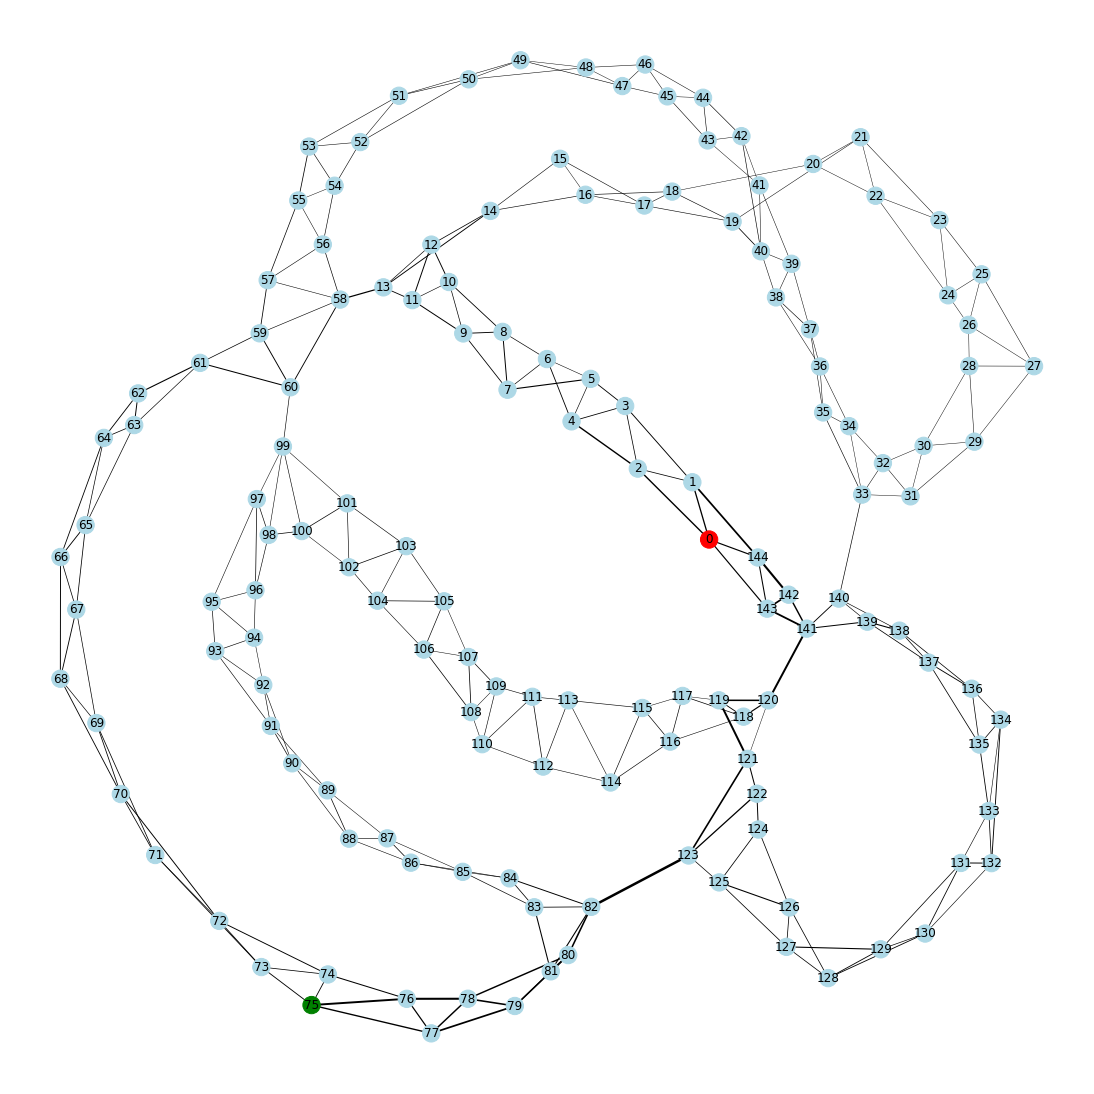

In [33]:
p = np.ones_like(m.todense())
aco = ACO(start=graphstart, goal=graphgoal, pheromones=p, adjacency=m.todense(), alpha=0.8, beta=0.2)
aco.run(generations=1000)
plt.figure(figsize=(15,15))
aco.draw_pheromones(label=False)
plt.show()

In [34]:
widgets.interact(aco.draw_pheromones, label=False, width=15, height=15, show=widgets.fixed(True), generation=widgets.IntSlider(min=0,max=len(aco.pheromone_timeline)-1,step=1,value=0));



interactive(children=(Checkbox(value=False, description='label'), IntSlider(value=0, description='generation',…

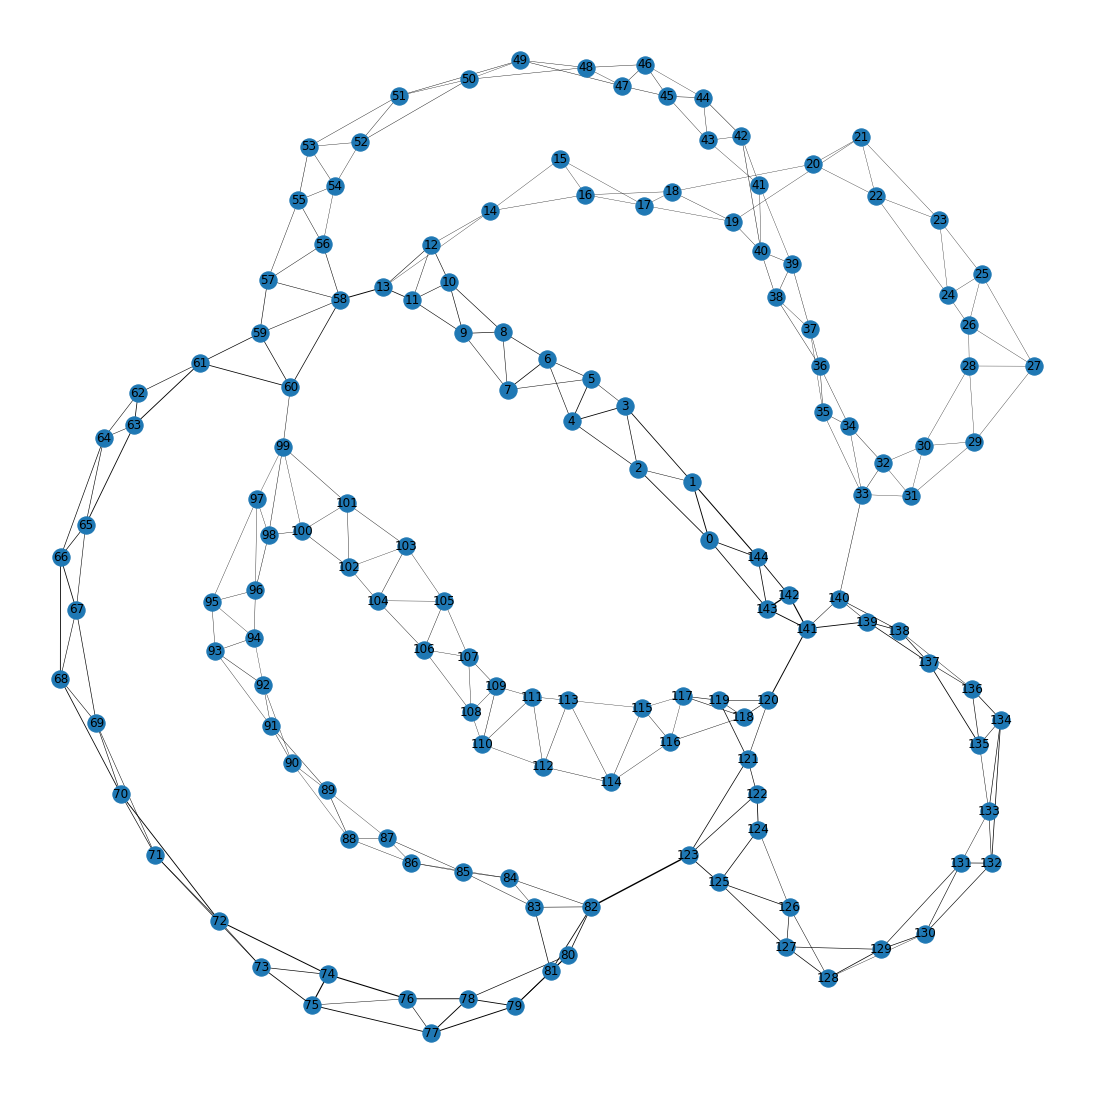

In [12]:
aco.draw_pheromones(label=False)

In [41]:
def drawfunction(generation):
    plt.figure(figsize=(15,15))
    a = Ant(pheromones=pheromone_timeline[generation], adjacency=m.todense())
    a.draw_pheromones(label=False)
    plt.show()
    
widgets.interact(drawfunction, generation=widgets.IntSlider(min=0,max=len(pheromone_timeline)-1,step=1,value=10));

interactive(children=(IntSlider(value=10, description='generation', max=999), Output()), _dom_classes=('widget…

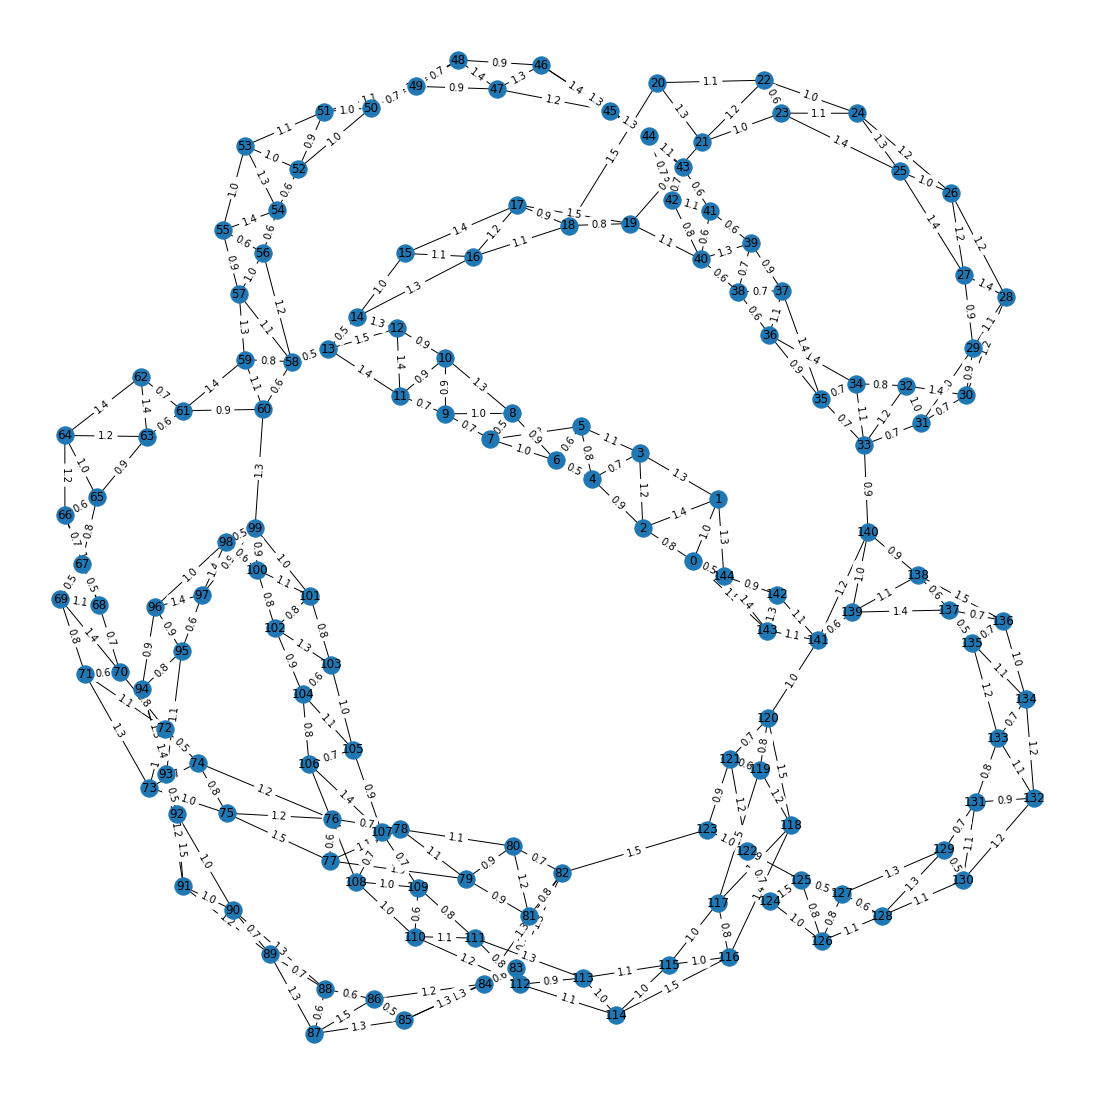

In [9]:
#a.pheromones
plt.figure(figsize=(15,15))
ants[0].draw_adjacency()
plt.show()



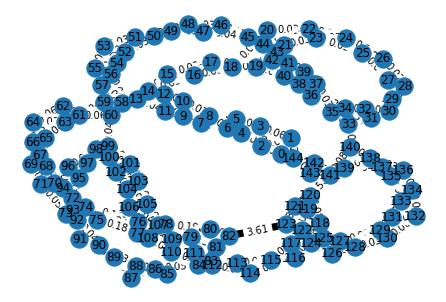

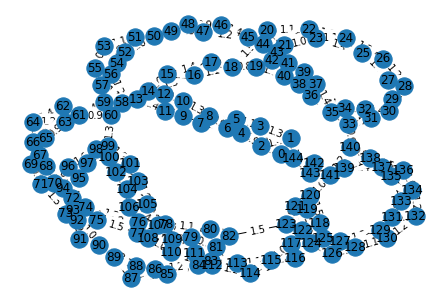

In [10]:
a.draw_pheromones()
plt.show()
a.draw_adjacency()
plt.show()

In [11]:
m

<145x145 sparse matrix of type '<class 'numpy.float64'>'
	with 580 stored elements in Compressed Sparse Row format>

In [12]:
adj = m.todense()

In [13]:
len(adj)

145

In [14]:
l = 0.2
f"{l:.2f}"

'0.20'

In [15]:
G.edges(data=True)

EdgeDataView([(0, 1, {'weight': 1.030317808359084}), (0, 144, {'weight': 0.5115441670356644}), (0, 2, {'weight': 0.828633887137541}), (0, 143, {'weight': 1.4847067773386153}), (1, 2, {'weight': 1.3531741222048912}), (1, 3, {'weight': 1.2533144130949412}), (1, 144, {'weight': 1.2649573770075184}), (2, 3, {'weight': 1.2092705499404242}), (2, 4, {'weight': 0.9255096501769356}), (3, 4, {'weight': 0.7396525322295773}), (3, 5, {'weight': 1.0707792122531061}), (4, 5, {'weight': 0.8156104267319352}), (4, 6, {'weight': 0.5483532470368052}), (5, 6, {'weight': 0.630744115925125}), (5, 7, {'weight': 1.2579213218541776}), (6, 7, {'weight': 0.9549092247694161}), (6, 8, {'weight': 0.8614381338112047}), (7, 8, {'weight': 0.535329321693855}), (7, 9, {'weight': 0.7154411190296125}), (8, 9, {'weight': 1.0246975141443988}), (8, 10, {'weight': 1.2621108123028597}), (9, 10, {'weight': 0.8947054874517444}), (9, 11, {'weight': 0.7022955748647837}), (10, 11, {'weight': 0.9257215940271049}), (10, 12, {'weight':